In [2]:
import json
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
#scales the axis to fit the picture
def make_axis_scale_equal():
    x_min, x_max, y_min, y_max = plt.axis()
    a_min = x_min if x_min < y_min else y_min
    a_max = x_max if x_max > y_max else y_max
    plt.axis([a_min, a_max, a_min, a_max])

def plot_picture(picture, path=None, save=False, axis=None, dpi=None):
    last_point = None
    #draw a line between the last and the current point; 
    #   red if the current point is a new stroke
    #   color_gradient if the current point is a continuation
    for i, p in enumerate(picture['data']):
        if 'new_begin' in p:
            color = 'red'
            marker = 's'
            linestyle = '--'
        else:
            color = plt.cm.viridis(float(i) / len(picture['data']))
            marker = 'o'
            linestyle = '-'

        plt.plot(p['x'], p['y'], color=color, linestyle='None', marker=marker, markersize=10)

        #connect the current and last point with a line
        if last_point is not None:
            plt.plot([last_point['x'], p['x']], [last_point['y'], p['y']], color=color, 
                     linewidth=7, linestyle=linestyle)

        last_point = p 

    make_axis_scale_equal()

    #sets the graphs background/face-color
    plt.gca().set_facecolor((0.6, 0.6, 0.6))
    
    #plot it in this document; doesn't save
    if not save:
        plt.title(picture['label'])
        plt.show()

In [4]:
def reduce_size(picture, data_len, vector_len):
    
    remove = data_len - vector_len
    step = data_len/remove
    
    #x contains the indices of values which have to be deleted
    x = np.arange(0, data_len-1, step).astype(int)
    
    #from back to front to not mess up the indices when deleting elements
    #ignore the last element in x 
    for i in x[::-1]:
        if 'new_begin' in picture['data'][i]:
            del(picture['data'][i-1])
        else:
            del(picture['data'][i])
            
    return picture

In [5]:
def get_longest_dist_index(picture):
    max_dist = 0
    pos = 0
    last_data = picture['data'][0]
    for index, data in enumerate(picture['data'][:-1]):
        x = data['x'] - last_data['x']
        y = data['y'] - last_data['y']
        
        last_data = data
        
        if 'new_begin' in data or 'new_begin' in last_data:
            continue
        
        if np.sqrt(x*x + y*y) > max_dist:
            max_dist = np.sqrt(x*x + y*y)
            pos = index        
        
    return pos

In [6]:
def create_new_point(prev_p, next_p):
    new_point = {}
    
    x_diff = next_p['x'] - prev_p['x']
    y_diff = next_p['y'] - prev_p['y']
    t_diff = next_p['time'] - prev_p['time']
    
    new_point['x'] = prev_p['x'] + x_diff/2
    new_point['y'] = prev_p['y'] + y_diff/2
    new_point['time'] = prev_p['time'] + t_diff/2
    
    return new_point

In [7]:
def increase_size(picture, data_len, vector_len):
    
    while(len(picture['data']) < vector_len):
        
        index = get_longest_dist_index(picture)
        point = create_new_point(picture['data'][index-1], picture['data'][index])
        picture['data'].insert(index, point)
    
    return picture    

In [8]:
def fit_vector_len(in_picture, vector_len = 32):
    data_len = len(in_picture['data'])
    if data_len == vector_len:
        picture = letter
    elif data_len < vector_len:
        picture = increase_size(in_picture, data_len, vector_len)
    elif data_len > vector_len:
        picture = reduce_size(in_picture, data_len, vector_len)

    return picture

In [68]:
def fit_to_border(picture, x=22, y=70): #can be adjusted; x should remain at 22 tho
    
    x_seq = [x['x'] for x in picture['data']]
    y_seq = [y['y'] for y in picture['data']]

    x_min = min(x_seq)
    x_max = max(x_seq)
    width = x_max - x_min

    y_min = min(y_seq)
    y_max = max(y_seq)
    height = y_max - y_min
    new_height = height

    print(width)
    print(height)
    if width > x:
        for i in range(len(picture['data'])):
            picture['data'][i]['x'] = np.round(float(picture['data'][i]['x'] * (x/width)), decimals=3) 
            picture['data'][i]['y'] = np.round(float(picture['data'][i]['y'] * (x/width)), decimals=3) 
            new_height = height * (x/width)

    elif width < x:
        for i in range(len(picture['data'])):
            picture['data'][i]['x'] = np.round(float(picture['data'][i]['x'] * (width/x)), decimals=3) 
            picture['data'][i]['y'] = np.round(float(picture['data'][i]['y'] * (width/x)), decimals=3)
            new_height = height * (width/x)

    if new_height > y:
        for i in range(len(picture['data'])):
            picture['data'][i]['x'] = np.round(float(picture['data'][i]['x'] * (y/new_height)), decimals=3) 
            picture['data'][i]['y'] = np.round(float(picture['data'][i]['y'] * (y/new_height)), decimals=3)        

    return picture        

In [69]:
def save(picture):
#example:
#{{7.5, 10.0, 1.0}, {7.5, 20.0, 1.0}, {-22.5, 30.0, 0.0}, {7.5, -10.0, 0.0}};
    out = "{"
    prev = picture['data'][0]
    DATALEN = 0
    for data in picture['data'][1:]:
        if(data['y']-prev['y'] < 0.3 and data['x']-prev['x'] < 0.3):
            continue
        out += "{" + str(np.round(float(data['x']-prev['x']), decimals=3)) + ","
        out += str(np.round(float(data['y']-prev['y']), decimals=3)) + ","
        out +=  str(1.0 if 'new_begin' in data else 0.0) + "},"
        prev = data
        DATALEN += 1
    out = out[:-1]
    out += "};"

    with open(picture['label'] + "_LEN_"+ str(DATALEN) + ".cArray", "w") as outfile:
        outfile.write(out)

733.8100000000001
782.22


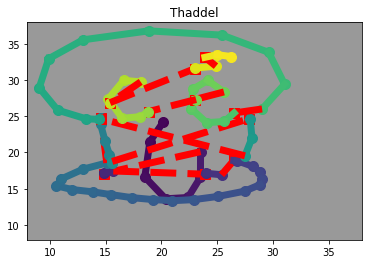

81


In [70]:
picture = json.load(open("thaddel.json", "r"));

f_l_128 = fit_vector_len(picture, 512)
#have to use +1 to increase the number of points for the last step
f_l_32 = fit_vector_len(f_l_128, 80+1)
fitted_picture = fit_to_border(f_l_32)

plot_picture(fitted_picture)
print(len(fitted_picture['data']))
save(fitted_picture)

128
